<a href="https://colab.research.google.com/github/kshitijmamgain/NLP/blob/master/NLP_SVM_CB_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [0]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [0]:
tweet = pd.read_csv('train.csv')
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# New Section

### Data Exploration
We see 3 columns let us find the information on the data

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Text(0, 0.5, 'Number of reviews')

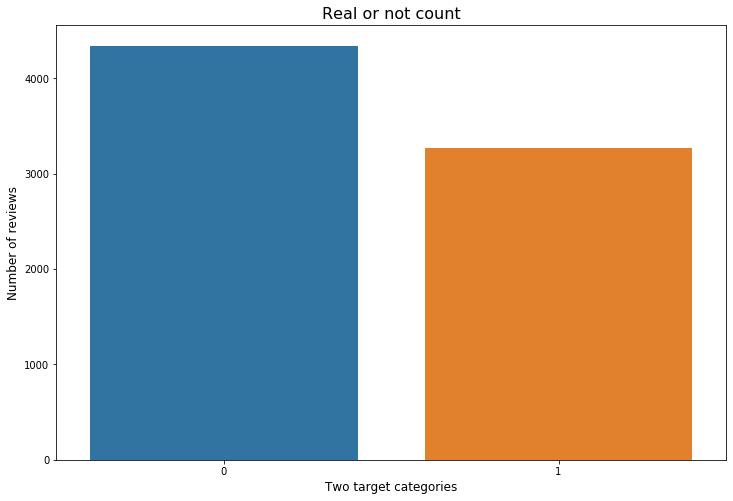

In [0]:
plt.figure(figsize = (12,8))
sns.countplot(tweet['target'])
plt.title("Real or not count", size = 16)
plt.xlabel(xlabel='Two target categories', size = 12)
plt.ylabel(ylabel='Number of reviews', size = 12)

Let us find out if the text length is of any significance in identifying the fake or real

In [0]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 0, 'Word count in each tweet')

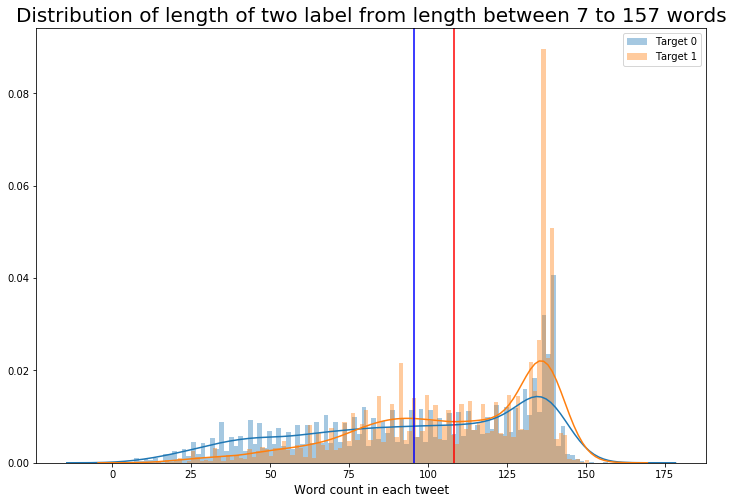

In [0]:
plt.figure(figsize = (12,8))
sns.distplot(tweet[tweet['target']==0]['text'].apply(lambda x: len(x)), bins = 100, label = "Target 0")
sns.distplot(tweet[tweet['target']==1]['text'].apply(lambda x: len(x)), bins = 100, label = "Target 1")
plt.title("Distribution of length of two label from length between {} to {} words".format(min(tweet['text'].apply(lambda x: len(x))),
                                                                            max(tweet['text'].apply(lambda x: len(x)))), size = 20)
plt.legend()
plt.axvline(x = np.mean(tweet[tweet['target']==0]['text'].apply(lambda x: len(x))), color = 'blue')
plt.axvline(x = np.mean(tweet[tweet['target']==1]['text'].apply(lambda x: len(x))), color = 'red')

plt.xlabel(xlabel='Word count in each tweet', size = 12)

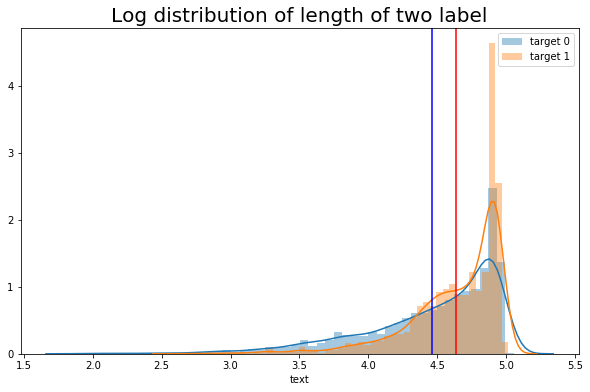

In [0]:

import numpy as np 

plt.figure(figsize = (10,6))
sns.distplot(tweet[tweet['target']==0]['text'].apply(lambda x: np.log(len(x))), bins = 50, label = "target 0")
sns.distplot(tweet[tweet['target']==1]['text'].apply(lambda x: np.log(len(x))), bins = 50, label = "target 1")
plt.title("Log distribution of length of two label", size = 20)
plt.legend()
plt.axvline(x = np.mean(tweet[tweet['target']==0]['text'].apply(lambda x: np.log(len(x)))), color = 'blue')
plt.axvline(x = np.mean(tweet[tweet['target']==1]['text'].apply(lambda x: np.log(len(x)))), color = 'red')

Let us apply t-test to see whether the difference is of any statistical significance

In [0]:
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
a = tweet[tweet['target']==0]['text'].apply(lambda x: np.log(len(x))).values
b = tweet[tweet['target']==1]['text'].apply(lambda x: np.log(len(x))).values
ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=-17.83654210505307, pvalue=9.758383661861326e-70)

The t-test proves that it could be good idea to put the length of the tweet as a feature for prediction let us try to plot the confidence interval

Text(0.5, 0, 'Word count in each tweet')

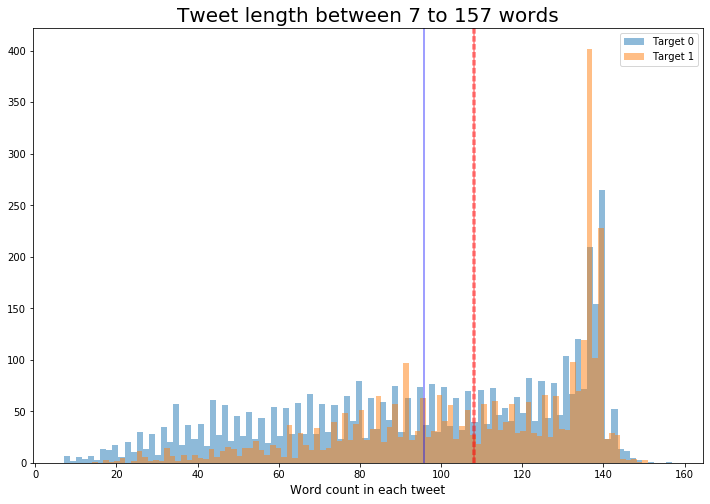

In [0]:
# t-test for independent variables with unequal variance
import statsmodels.stats.weightstats as ws
means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
confint = means.tconfint_diff(alpha=0.01, alternative='two-sided', usevar='unequal') # confidence with 95%
degfree = means.dof_satt()

plt.figure(figsize = (12,8))
plt.hist(tweet[tweet['target']==0]['text'].apply(lambda x: len(x)), bins = 100, label = "Target 0", alpha = 0.5)
plt.hist(tweet[tweet['target']==1]['text'].apply(lambda x: len(x)), bins = 100, label = "Target 1", alpha = 0.5)
plt.title("Tweet length between {} to {} words".format(min(tweet['text'].apply(lambda x: len(x))),
                                                                            max(tweet['text'].apply(lambda x: len(x)))), size = 20)
plt.legend()
plt.axvline(x = np.mean(tweet[tweet['target']==0]['text'].apply(lambda x: len(x))), color = 'blue', alpha = 0.5)
plt.axvline(x = np.mean(tweet[tweet['target']==1]['text'].apply(lambda x: len(x))), color = 'red', alpha = 0.5)
# adding confidence interval
plt.axvline(x = (np.mean(tweet[tweet['target']==1]['text'].apply(lambda x: len(x)))-confint[1]), color = 'red',
            linestyle='--',alpha = 0.5)
plt.axvline(x = (np.mean(tweet[tweet['target']==1]['text'].apply(lambda x: len(x)))+confint[0]), color = 'red',
            linestyle='--',alpha = 0.5)
plt.xlabel(xlabel='Word count in each tweet', size = 12)

Stats tell us that it would be a good idea to keep length as feature. Let us also try to visualize this with boxplot

Text(0.5, 1.0, 'Boxplot visualization for 2 target classes')

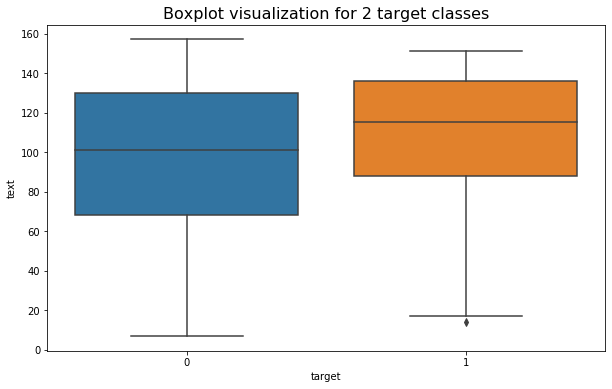

In [0]:
plt.figure(figsize = (10,6))
sns.boxplot(x = 'target', y = tweet['text'].apply(lambda x: len(x)), data = tweet)
plt.title("Boxplot visualization for 2 target classes", size = 16)

Seeing the distribution and the statistics let us add the tweet length as one of the features

#### Data Preprocessing

In [0]:
def twt_length(text_col):
    return text_col.apply(lambda x: len(x))    

In [0]:
tweet['length'] = twt_length(tweet['text'])

In [0]:
tweet.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [0]:
tweet['id'].nunique()

7613

In [0]:
tweet.shape

(7613, 6)

In [0]:
tweet['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [0]:
tweet.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

As there are no missing values we'll make process the text

In [0]:
from nltk.tokenize import word_tokenize

In [65]:
import nltk 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
# Step - a : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
tweet['text'] = [str.lower(txt) for txt in tweet['text']]

# Step - b : Tokenization : In this each entry in the corpus will be broken into set of words
tweet['text'] = [word_tokenize(txt) for txt in tweet['text']]

tweet.head(3)

,id,keyword,location,text,target,length
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, #, ea...",1,69
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, ., canada]",1,38
2,5,NaN,NaN,"[all, residents, asked, to, 'shelter, in, plac...",1,133


In [0]:
from nltk.corpus import stopwords

In [0]:
# Step - c : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
tweet['stp_text'] = tweet['text'].apply(lambda x: [word for word in x if (word not in stopwords.words('english'))& (word.isalpha())])

In [0]:
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [0]:
#Step - e
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
"""
1. pos tag function
2. Define a function for lemmatizing
"""
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

def word_lemmatizer(series):
  """lemmatizes words in series to their root using POS tag"""
  
  count = series.shape[0] # number of inputs
  txt_series = series.copy()
  lemmatizer = WordNetLemmatizer() # initializing lemmatizer
  
  for i in range(count):
    tst = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in txt_series.iloc[i]]
    txt_series.iloc[i] = tst
  
  return(txt_series)

# a new column with lemmatized words
tweet['lem_txt'] = word_lemmatizer(tweet['stp_text'])
tweet.head()

,id,keyword,location,text,target,length,stp_text,lem_txt
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, #, ea...",1,69,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, ., canada]",1,38,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,"[all, residents, asked, to, 'shelter, in, plac...",1,133,"[residents, asked, place, notified, officers, ...","[resident, ask, place, notify, officer, evacua..."
3,6,NaN,NaN,"[13,000, people, receive, #, wildfires, evacua...",1,65,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,"[just, got, sent, this, photo, from, ruby, #, ...",1,88,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [0]:
#step f
#The above dataframe gives us the list of final text but for TF-IDF we need the input as string. So we can create a final column with lambda function
tweet['text_final'] = tweet['lem_txt'].apply(lambda x: ' '.join(x))
tweet['text_final']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident ask place notify officer evacuation s...
3       people receive wildfire evacuation order calif...
4       get sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane hold bridge collapse nearby ho...
7609    thetawniest control wild fire california even ...
7610                              utc volcano hawaii http
7611    police investigate collide car little portugal...
7612    late home raze northern california wildfire ab...
Name: text_final, Length: 7613, dtype: object

In [0]:
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Prepare Evaluate/ Train Datasets

In [0]:
train_X, val_X, train_y, val_y = model_selection.train_test_split(tweet['text_final'],tweet['target'],test_size=1/3, random_state = 10)

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=10000)
Tfidf_vect.fit(train_X)
Train_X_Tfidf = Tfidf_vect.transform(train_X)
Val_X_Tfidf = Tfidf_vect.transform(val_X)
train_X.head()

1827                 pak army helicopter crashed mansehra
3104    constantly electrocute know chance stand next ...
4840    aurora theater shoot trial gunman expect notor...
379     one direction pick http fan army directioners ...
7403    officer wound suspect kill exchange gunfire ri...
Name: text_final, dtype: object

In [0]:
Tfidf_vect.get_feature_names()[5000:5010]

['lawsonofficial',
 'lawsuit',
 'lawton',
 'lay',
 'laylovetournay',
 'layout',
 'lbr',
 'lcb',
 'lcc',
 'le']

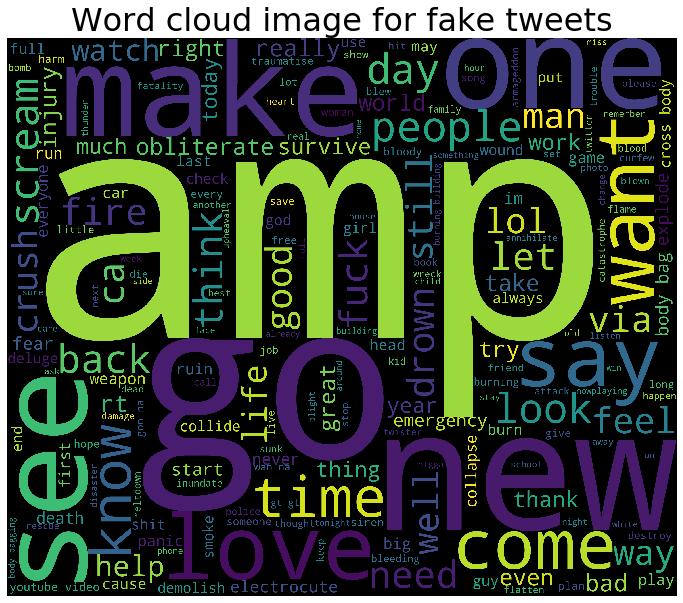

In [0]:
# Way to create image from simple word count
from wordcloud import WordCloud, STOPWORDS
words = ' '.join(tweet[tweet['target'] ==0]['text_final'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
                     
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.title("Word cloud image for fake tweets", size = 32)
plt.axis('off')
plt.show()

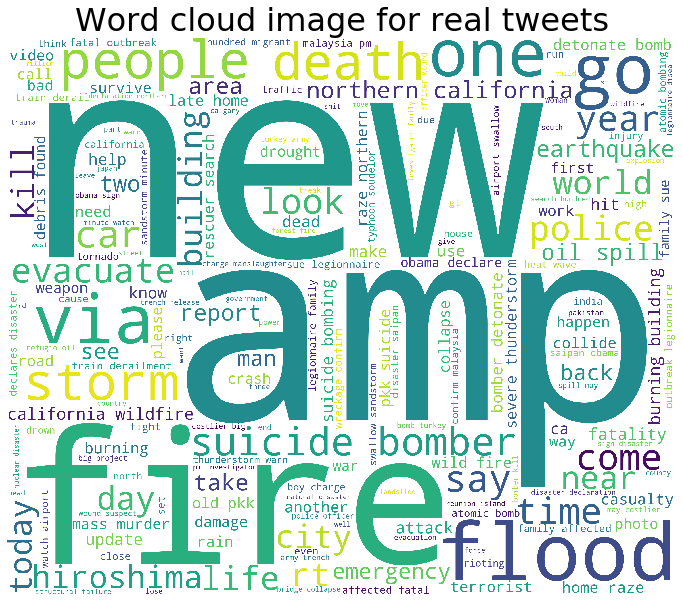

In [0]:
words = ' '.join(tweet[tweet['target'] ==1]['text_final'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(words)
                     
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.title("Word cloud image for real tweets", size = 32)
plt.axis('off')
plt.show()

#### ML Models

In [0]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(Train_X_Tfidf,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions_LR = LR.predict(Val_X_Tfidf)
print("LR Accuracy Score -> ",accuracy_score(predictions_LR, val_y)*100)

LR Accuracy Score ->  80.49645390070921


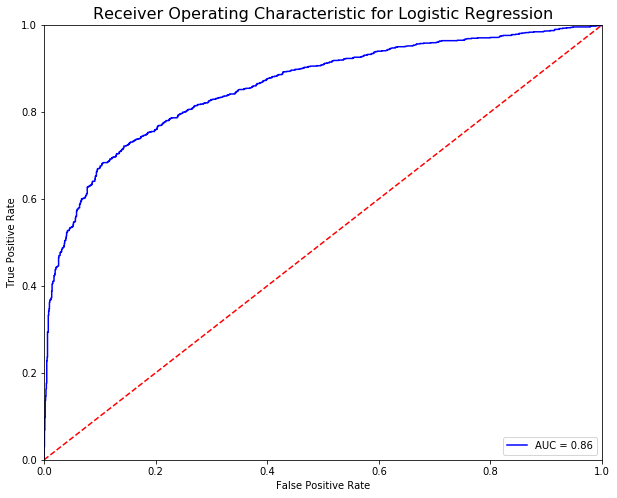

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = LR.predict_proba(Val_X_Tfidf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(val_y, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.title('Receiver Operating Characteristic for Logistic Regression', size = 16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic: f1=0.748 auc=0.845


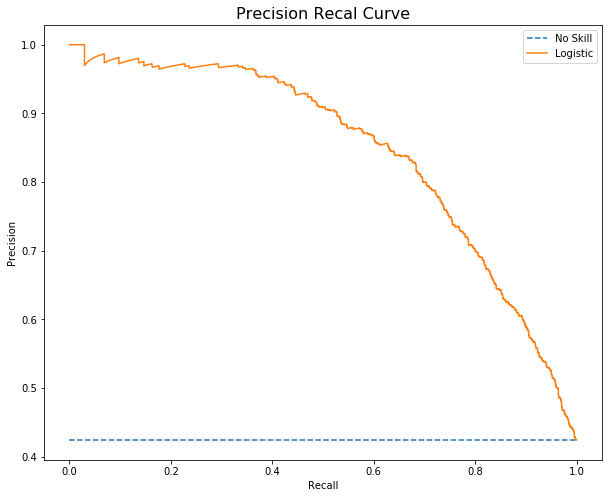

In [0]:
from sklearn.metrics import precision_recall_curve

# predict probabilities
lr_probs = LR.predict_proba(Val_X_Tfidf)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = LR.predict(Val_X_Tfidf)
lr_precision, lr_recall, _ = precision_recall_curve(val_y, lr_probs)
lr_f1, lr_auc = metrics.f1_score(val_y, yhat), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(val_y[val_y==1]) / len(val_y)
plt.figure(figsize = (10,8))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, label='Logistic')
# axis labels
plt.title('Precision Recal Curve', size = 16)
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

Lets try with SVM

In [0]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear')
SVM.fit(Train_X_Tfidf,train_y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Val_X_Tfidf)

In [0]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, val_y)*100)

SVM Accuracy Score ->  79.86603624901497


In [0]:
confusion_matrix(val_y,predictions_SVM)

array([[1267,  194],
       [ 317,  760]])

Let's try to optimize the loss function using hyperopt

In [0]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [0]:
# defining the space for hyperparameter tuning
space={'C': hp.uniform('C', 0.1, 100),
        'gamma': hp.uniform('gamma', 0.1, 15),
        'degree' : hp.quniform('degree', 1,10,1),
        'kernel': 'linear'
    }

In [0]:
def hyperparameter_tuning(space):
    SVM=svm.SVC(C =space['C'], 
                gamma = space['gamma'],
                degree = space['degree'],
                kernel = space['kernel'])
        
    SVM.fit(Train_X_Tfidf, train_y)

    pred = SVM.predict(Val_X_Tfidf)
    accuracy = accuracy_score(val_y, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK }

In [0]:
# run the hyper paramter tuning
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

SCORE:
0.7568951930654059
SCORE:
0.7509850275807722
SCORE:
0.7462568951930654
SCORE:
0.7505910165484634
SCORE:
0.7722616233254531
SCORE:
0.7494089834515366
SCORE:
0.7454688731284476
SCORE:
0.7454688731284476
SCORE:
0.7903861308116628
SCORE:
0.7568951930654059
SCORE:
0.7486209613869188
SCORE:
0.7541371158392435
SCORE:
0.7561071710007881
SCORE:
0.7462568951930654
SCORE:
0.7454688731284476
SCORE:
0.7454688731284476
SCORE:
0.747832939322301
SCORE:
0.7462568951930654
SCORE:
0.7454688731284476
SCORE:
0.7525610717100079
SCORE:
0.7702915681639085
SCORE:
0.7821118991331757
SCORE:
0.7702915681639085
SCORE:
0.7671394799054374
SCORE:
0.7655634357762018
SCORE:
0.793538219070134
SCORE:
0.7667454688731284
SCORE:
0.7513790386130812
SCORE:
0.7588652482269503
SCORE:
0.7505910165484634
SCORE:
0.768715524034673
SCORE:
0.7494089834515366
SCORE:
0.7458628841607565
SCORE:
0.7939322301024428
SCORE:
0.7608353033884949
SCORE:
0.7509850275807722
SCORE:
0.80575256107171
SCORE:
0.7501970055161544
SCORE:
0.75531914

In [0]:
SVM=svm.SVC(C =best['C'], 
            gamma = best['gamma'],
            degree = best['degree'],
            kernel = 'linear')
SVM.fit(Train_X_Tfidf,train_y)

SVC(C=0.698740702566051, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=4.0,
    gamma=0.937126163456043, kernel='linear', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [0]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Val_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, val_y)*100)

SVM Accuracy Score ->  80.575256107171


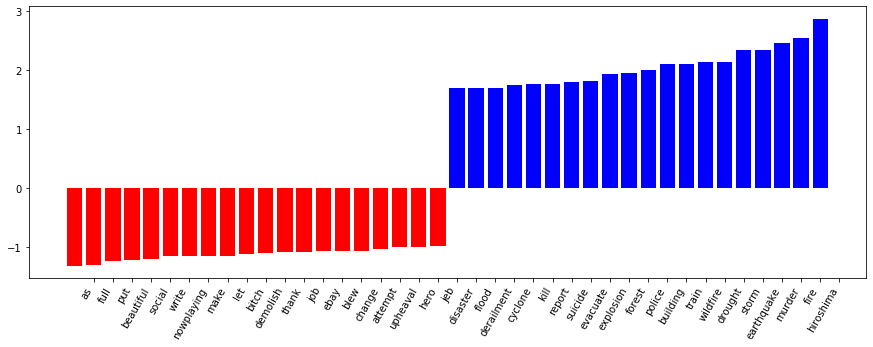

In [0]:
import numpy
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.toarray().reshape(-1)
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

plot_coefficients(SVM, Tfidf_vect.get_feature_names())

#### NLP with Catboost

The catboost model has novel approach to also take othe columns into consideration

In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 50kB/s 


In [0]:
from catboost import Pool, CatBoostClassifier

In [0]:
tweet.head()

,id,keyword,location,text,target,length,stp_text,lem_txt,text_final
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, #, ea...",1,69,"[deeds, reason, earthquake, may, allah, forgiv...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, ., canada]",1,38,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,"[all, residents, asked, to, 'shelter, in, plac...",1,133,"[residents, asked, place, notified, officers, ...","[resident, ask, place, notify, officer, evacua...",resident ask place notify officer evacuation s...
3,6,NaN,NaN,"[13,000, people, receive, #, wildfires, evacua...",1,65,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfire, evacuation, order,...",people receive wildfire evacuation order calif...
4,7,NaN,NaN,"[just, got, sent, this, photo, from, ruby, #, ...",1,88,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfire pour...


In [0]:
cat_features = ['keyword']
text_features = ['text_final']

In [0]:
# we can create a new test model
train_X, val_X, train_y, val_y = model_selection.train_test_split(tweet[['text_final','keyword','length']],tweet['target'],test_size=1/3, random_state = 10)

In [0]:
#fill NaN in keyword with blank space
def fill_na(df, features):
  for feature in features:
    df[feature].fillna('', inplace=True)

fill_na(train_X,cat_features)
fill_na(val_X,cat_features)

In [0]:
train_X.isnull().sum()

text_final    0
keyword       0
length        0
dtype: int64

In [0]:

def real_or_not_tweet(X_train, X_test, y_train, y_test, catboost_params={}, verbose=200):
    learn_pool = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
    
    catboost_default_params = {
        'iterations': 2000,
        'learning_rate': 0.03,
        'eval_metric': 'Accuracy',
        'task_type': 'GPU'
        
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose, 
              early_stopping_rounds = 100)

    return model

In [0]:
cbc = real_or_not_tweet(train_X, val_X, train_y, val_y)

0:	learn: 0.7718227	test: 0.7947203	best: 0.7947203 (0)	total: 43.6ms	remaining: 1m 27s
bestTest = 0.8073286052
bestIteration = 88
Shrink model to first 89 iterations.


We see Catboost is performing slightly better than the svm. Let us try to tune the model

In [0]:
from sklearn.metrics import accuracy_score, f1_score
learn_pool = Pool(train_X, train_y, cat_features=cat_features, 
                  text_features=text_features, feature_names=list(train_X))
val_pool = Pool( val_X, val_y, cat_features=cat_features,
                 text_features=text_features, feature_names=list(train_X))

def objective(space):
    # Instantiate the classifier
    clf = CatBoostClassifier(learning_rate = space['learning_rate'], 
                                 n_estimators =int(space['n_estimators']), 
                                 max_depth = int(space['max_depth']),
                                 reg_lambda = int(space['reg_lambda']),
                                 
                                 bagging_temperature = space['bagging_temperature'],
                             task_type = 'GPU')
    
    
    # Fit the classsifier
    clf.fit(learn_pool,
            eval_set=val_pool, 
            early_stopping_rounds=10,verbose=False)
    
    # Predict on Cross Validation data
    pred = clf.predict(val_X)
    
    # Calculate our Metric - accuracy
    fscore = f1_score(val_y, pred>0.5)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -fscore, 'status': STATUS_OK }

space =    {
     'learning_rate':     hp.choice('learning_rate',     np.arange(0.01, 0.8, 0.05)),
     'max_depth':         hp.choice('max_depth',         np.arange(2, 16, 1, dtype=int)),
     'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
     'n_estimators':      hp.quniform('n_estimators', 500, 5000,100),
     'reg_lambda' :       hp.uniform('reg_lambda', 0,5),
     'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 100)

    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=40,
            trials=trials)
print(best)


100%|██████████| 40/40 [11:34<00:00, 14.18s/it, best loss: -0.7616279069767441]
{'bagging_temperature': 13.528001661404787, 'colsample_bylevel': 0.5619511092230439, 'learning_rate': 6, 'max_depth': 6, 'n_estimators': 2100.0, 'reg_lambda': 0.5587961367147581}


In the above optimization we tried to find hyper parameters for best f1 score for which we have got the value of 0.76

We see that the base model with less data are performing best with upto 80% of accuracy. 

To get better results we'll try the pretrained model like BERT

In [2]:
!pip install transformers

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 870kB 51.1MB/s 
     |████████████████████████████████| 1.0MB 37.3MB/s 
     |████████████████████████████████| 3.7MB 30.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=140ea972a201919c73bd545fe106a32f811c8504511ce8d8fcbc85152c4471fb
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [3]:
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
from torch.utils.data import Dataset, DataLoader

class LoadDataset(Dataset):

    def __init__(self, filename, maxlen):

        # Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter=',')

        # Initialize the BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Define the Maxlength for padding/truncating
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        # Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'text']
        label = self.df.loc[index, 'target']

        # Tokenize the sentence
        tokens = self.tokenizer.tokenize(sentence)

        # Inserting the CLS and SEP token at the beginning and end of the sentence
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        
        # Padding/truncating the sentences to the maximum length
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']
        
        # Convert the sequence to ids with BERT Vocabulary
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        
        # Converting the list to a pytorch tensor
        tokens_ids_tensor = torch.tensor(tokens_ids)

        # Obtaining the attention mask
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [6]:
import pandas as pd

bert_df = pd.read_csv('train.csv')
bert_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
#train, val = train_test_split(bert_df[['text','target']],test_size=1/3, random_state = 10)


train.to_csv('learn.csv')

val.to_csv('val.csv')

NameError: ignored

In [0]:
# Creating instances of training and validation set
train_set = LoadDataset( 'learn.csv', maxlen = 64)
val_set = LoadDataset('val.csv', maxlen = 64)

In [0]:
# Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 16, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 16, num_workers = 5)

#### Building the model

In [0]:
from torch import nn
class RealOrNotClassifier(nn.Module):

    def __init__(self, freeze_bert = True):
        super(RealOrNotClassifier, self).__init__()

        # Instantiating the BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        # Defining layers like dropout and linear
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        # Getting contextualized representations from BERT Layer
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        # Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]
        # print('CLS shape: ',cls_rep.shape)

        # Feeding cls_rep to the classifier layer
        logits = self.classifier(cls_rep)
        # print('Logits shape: ',logits.shape)

        return logits

In [0]:
model = RealOrNotClassifier()

In [0]:
import torch
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr = 2e-5)

In [13]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(device)

cuda


In [0]:

# Defining a function for calculating accuracy
def logits_accuracy(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    preds = (probs > 0.5).long()
    acc = (preds.squeeze() == labels).float().mean()
    return acc

In [0]:
# Defining an evaluation function for training 
def evaluate(net, criterion, val_loader, device):
  
    losses, accuracies = 0, 0
    
    # Setting model to evaluation mode
    net.eval()

    count = 0
    for (seq, attn_masks, labels) in val_loader:
        count += 1

        # Move inputs and targets to device
        seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

        # Get logit predictions
        val_logits = net(seq, attn_masks)

        # Calculate loss
        val_loss = criterion(val_logits.squeeze(-1), labels.float())
        losses += val_loss.item()

        # Calculate validation accuracy
        accuracies += logits_accuracy(val_logits, labels)

    return losses / count, accuracies / count

In [0]:
from time import time
def train(net, criterion, optimizer, train_loader, val_loader, device, epochs=4, print_every=100):
    
    # Move model to device
    net.to(device)
    # Setting model to training mode
    net.train()

    print('========== ========== STARTING TRAINING ========== ==========')

    for epoch in range(epochs):

        print('\n\n========== EPOCH {} =========='.format(epoch))        
        t1 = time()

        for i, (seq, attn_masks, labels) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()  

            # Moving tensors to device
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

            # Obtaining the logits from the model
            logits = net(seq,attn_masks)

            # Calculating the loss
            loss = criterion(logits.squeeze(-1), labels.float())

            # Backpropagating the gradients
            loss.backward()

            # Clipping gradients to tackle exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), 1)

            # Optimization step
            optimizer.step()

            if (i + 1) % print_every == 0:
                print("Iteration {} ==== Loss: {}".format(i+1, loss.item()))

        t2 = time()
        print('Time Taken for Epoch: {}'.format(t2-t1))
        print('\n========== Validating ==========')
        mean_val_loss, mean_val_acc = evaluate(net, criterion, val_loader, device)
        print("Validation Loss: {}\nValidation Accuracy: {}".format(mean_val_loss, mean_val_acc))

In [17]:
%%time
# starting training
train(model, criterion, optimizer, train_loader, val_loader, device, epochs=4, print_every=100)

========== ========== STARTING TRAINING ========== ==========


========== EPOCH 0 ==========
Iteration 100 ==== Loss: 0.6662006974220276
Iteration 200 ==== Loss: 0.26924851536750793
Iteration 300 ==== Loss: 0.2650773525238037
Time Taken for Epoch: 49.05784487724304

========== Validating ==========
Validation Loss: 0.4478788243452455
Validation Accuracy: 0.8223726153373718


========== EPOCH 1 ==========
Iteration 100 ==== Loss: 0.4526395797729492
Iteration 200 ==== Loss: 0.13818755745887756
Iteration 300 ==== Loss: 0.1567506045103073
Time Taken for Epoch: 48.37510323524475

========== Validating ==========
Validation Loss: 0.46310113543632686
Validation Accuracy: 0.8350319266319275


========== EPOCH 2 ==========
Iteration 100 ==== Loss: 0.12622947990894318
Iteration 200 ==== Loss: 0.014433369040489197
Iteration 300 ==== Loss: 0.019341178238391876
Time Taken for Epoch: 48.322985887527466

========== Validating ==========
Validation Loss: 0.6723737174668795
Validation Accuracy: 0.8266

In [0]:
# Saving our model
import os
save_path = '/content/drive/My Drive/Colab Notebooks/bert'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, '/content/drive/My Drive/Colab Notebooks/bert/rnmodel1.pth')

In [21]:
# Loading the checkpoints for resuming training
checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/bert/rnmodel1.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [22]:

import torch
#predictions
# predictor
inference_file = torch.load('/content/drive/My Drive/Colab Notebooks/bert/rnmodel.pth')
predictor = RealOrNotClassifier()
predictor.load_state_dict(inference_file['model_state_dict'])

<All keys matched successfully>

In [0]:
def preprocess(sentence, maxlen=64):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize the sentence
    tokens = tokenizer.tokenize(sentence)

    # Inserting the CLS and SEP token at the beginning and end of the sentence
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    
    # Padding/truncating the sentences to the maximum length
    if len(tokens) < maxlen:
        tokens = tokens + ['[PAD]' for _ in range(maxlen - len(tokens))]
    else:
        tokens = tokens[:maxlen-1] + ['[SEP]']
    
    # Convert the sequence to ids with BERT Vocabulary
    tokens_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Converting the list to a pytorch tensor
    tokens_ids_tensor = torch.tensor(tokens_ids).unsqueeze(0)

    # Obtaining the attention mask
    attn_mask = (tokens_ids_tensor != 0).long()

    return tokens_ids_tensor, attn_mask

In [0]:
# Defining an evaluation function for training 
def predict(net, iseq, masks):
    device = 'cpu'
    # Setting model to evaluation mode
    net.eval()

    # Move inputs and targets to device
    iseq, masks = iseq.to(device), masks.to(device)

    # Get logit predictions
    p_logit = net(iseq, masks)

    probs = torch.sigmoid(p_logit.unsqueeze(-1))
    preds = (probs > 0.5).long().squeeze(0)

   
    return preds, probs

In [0]:
test_tokens, test_attn = comb(" Metro College of technology has helped me increase my knowledge for design and manufacture and be competitive in the market.")

In [46]:
float(test_attn.detach().numpy())

0.0041769095696508884

In [0]:
def comb(text):
  test_tokens, test_attn = preprocess(text)
  preds, probs = predict(predictor,test_tokens, test_attn)
  return (int(preds.numpy()), probs.detach().numpy())


In [0]:
trgt = []
prb = []
for twt in val.text.values:
  pred, proba = comb(twt)
  trgt.append(pred)
  prb.append(proba)

In [0]:
val = pd.read_csv('val.csv')
l = val.shape[0]
#l = 163
n = 0
p_list = pd.Series([])

In [0]:
while l/50 > 1:
  
  p_list = p_list.append(val['text'][n:n+50].apply(lambda x: comb(x)))
  n = n+50
  l = l-50
else:
  p_list = p_list.append(val['text'][0:l].apply(lambda x: comb(x)))


In [29]:
p_list

0       [[tensor(0)]]
1       [[tensor(1)]]
2       [[tensor(1)]]
3       [[tensor(0)]]
4       [[tensor(1)]]
            ...      
2496    [[tensor(1)]]
2497    [[tensor(0)]]
2498    [[tensor(0)]]
2499    [[tensor(0)]]
0       [[tensor(0)]]
Length: 2501, dtype: object

In [0]:
bert_df.head()

,id,keyword,location,text,target,cln_twt,cln_twt1,stp_text,lem_txt,text_final
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]","[deeds, reason, earthquake, may, allah, forgive, us]","[deed, reason, earthquake, may, allah, forgive, u]",our deeds are the reason of this # earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask . canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[all, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., no, other, evacuation, or, shelter, in, place, orders, are, expected]","[residents, asked, place, notified, officers, evacuation, shelter, place, orders, expected]","[resident, ask, place, notify, officer, evacuation, shelter, place, order, expect]",all residents asked to 'shelter in place ' are being notified by officers . no other evacuation or shelter in place orders are expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California","[13,000, people, receive, #, wildfires, evacuation, orders, in, california]","[people, receive, wildfires, evacuation, orders, california]","[people, receive, wildfire, evacuation, order, california]","13,000 people receive # wildfires evacuation orders in california"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[just, got, sent, this, photo, from, ruby, #, alaska, as, smoke, from, #, wildfires, pours, into, a, school]","[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]","[get, sent, photo, ruby, alaska, smoke, wildfire, pours, school]",just got sent this photo from ruby # alaska as smoke from # wildfires pours into a school


In [59]:
import re
text1 = 'RT @UniversalIND: #F8 is now playing in the theaters near you! So hurry and book your tickets https://www.abcabcabc.com'
text1 = re.sub(r'@\S+|http?s?://\S+', '', text1)

print(text1)

RT  #F8 is now playing in the theaters near you! So hurry and book your tickets 


In [0]:
def clean_tweet(text):
  text = re.sub(r'@\S+|http?s?://\S+', '', text)
  return(text)


In [0]:
bert_df['cln_twt'] = bert_df['text'].apply(lambda x: clean_tweet(x))

In [0]:
pd.set_option('display.max_colwidth', -1)
bert_df.tail(5)

,id,keyword,location,text,target,cln_twt
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,Two giant cranes holding a bridge collapse into nearby homes
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,The out of control wild fires in California even in the Northern part of the state. Very troubling.
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,The Latest: More Homes Razed by Northern California Wildfire - ABC News


In [0]:
# Step - a : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
bert_df['cln_twt1'] = [str.lower(txt) for txt in bert_df['cln_twt']]

# Step - b : Tokenization : In this each entry in the corpus will be broken into set of words
bert_df['cln_twt1'] = [word_tokenize(txt) for txt in bert_df['cln_twt1']]

bert_df.head(3)

,id,keyword,location,text,target,cln_twt,cln_twt1
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, ., canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[all, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., no, other, evacuation, or, shelter, in, place, orders, are, expected]"


In [0]:
bert_df.to_csv('clean_txt.csv')

In [0]:
bert_df[bert_df.duplicated('text')]['target'].value_counts()

1    73
0    37
Name: target, dtype: int64

In [0]:
# Step - c : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
bert_df['stp_text'] = bert_df['cln_twt1'].apply(lambda x: [word for word in x if (word not in stopwords.words('english'))& (word.isalpha())])

In [0]:
bert_df.head()

,id,keyword,location,text,target,cln_twt,cln_twt1,stp_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]","[deeds, reason, earthquake, may, allah, forgive, us]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[all, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., no, other, evacuation, or, shelter, in, place, orders, are, expected]","[residents, asked, place, notified, officers, evacuation, shelter, place, orders, expected]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California","[13,000, people, receive, #, wildfires, evacuation, orders, in, california]","[people, receive, wildfires, evacuation, orders, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[just, got, sent, this, photo, from, ruby, #, alaska, as, smoke, from, #, wildfires, pours, into, a, school]","[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]"


In [0]:
#Step - e
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
"""
1. pos tag function
2. Define a function for lemmatizing
"""
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wn.ADJ,
                "N": wn.NOUN,
                "V": wn.VERB,
                "R": wn.ADV}

    return tag_dict.get(tag, wn.NOUN)

def word_lemmatizer(series):
  """lemmatizes words in series to their root using POS tag"""
  
  count = series.shape[0] # number of inputs
  txt_series = series.copy()
  lemmatizer = WordNetLemmatizer() # initializing lemmatizer
  
  for i in range(count):
    tst = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in txt_series.iloc[i]]
    txt_series.iloc[i] = tst
  
  return(txt_series)

# a new column with lemmatized words
bert_df['lem_txt'] = word_lemmatizer(bert_df['stp_text'])
bert_df.head()

,id,keyword,location,text,target,cln_twt,cln_twt1,stp_text,lem_txt
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]","[deeds, reason, earthquake, may, allah, forgive, us]","[deed, reason, earthquake, may, allah, forgive, u]"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[all, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., no, other, evacuation, or, shelter, in, place, orders, are, expected]","[residents, asked, place, notified, officers, evacuation, shelter, place, orders, expected]","[resident, ask, place, notify, officer, evacuation, shelter, place, order, expect]"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California","[13,000, people, receive, #, wildfires, evacuation, orders, in, california]","[people, receive, wildfires, evacuation, orders, california]","[people, receive, wildfire, evacuation, order, california]"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[just, got, sent, this, photo, from, ruby, #, alaska, as, smoke, from, #, wildfires, pours, into, a, school]","[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]","[get, sent, photo, ruby, alaska, smoke, wildfire, pours, school]"


In [0]:
#step f
#The above dataframe gives us the list of final text but for TF-IDF we need the input as string. So we can create a final column with lambda function
bert_df['text_final'] = bert_df['cln_twt1'].apply(lambda x: ' '.join(x))
bert_df.head()

,id,keyword,location,text,target,cln_twt,cln_twt1,stp_text,lem_txt,text_final
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]","[deeds, reason, earthquake, may, allah, forgive, us]","[deed, reason, earthquake, may, allah, forgive, u]",our deeds are the reason of this # earthquake may allah forgive us all
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask . canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"[all, residents, asked, to, 'shelter, in, place, ', are, being, notified, by, officers, ., no, other, evacuation, or, shelter, in, place, orders, are, expected]","[residents, asked, place, notified, officers, evacuation, shelter, place, orders, expected]","[resident, ask, place, notify, officer, evacuation, shelter, place, order, expect]",all residents asked to 'shelter in place ' are being notified by officers . no other evacuation or shelter in place orders are expected
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California","[13,000, people, receive, #, wildfires, evacuation, orders, in, california]","[people, receive, wildfires, evacuation, orders, california]","[people, receive, wildfire, evacuation, order, california]","13,000 people receive # wildfires evacuation orders in california"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[just, got, sent, this, photo, from, ruby, #, alaska, as, smoke, from, #, wildfires, pours, into, a, school]","[got, sent, photo, ruby, alaska, smoke, wildfires, pours, school]","[get, sent, photo, ruby, alaska, smoke, wildfire, pours, school]",just got sent this photo from ruby # alaska as smoke from # wildfires pours into a school


In [0]:
bert_df.drop_duplicates('text',inplace = True)

In [0]:
val['pred'] = trgt
val['prob'] = prb

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(val['target'],val['pred']))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1428
           1       0.93      0.87      0.90      1073

    accuracy                           0.92      2501
   macro avg       0.92      0.91      0.92      2501
weighted avg       0.92      0.92      0.92      2501



In [52]:
confusion_matrix(val['target'],val['pred'])

array([[1362,   66],
       [ 137,  936]])

let us see the kind of tweets model is unable to guess right

In [0]:
pd.set_option('display.max_colwidth', -1)
val[val['target'] != val['pred']].to_csv('misclassified')

In [0]:

trgt = []
prb = []
for twt in val.text.values:
  pred, proba = comb(twt)
  trgt.append(pred)
  prb.append(proba)

In [0]:
val['pred'] = trgt
val['prob'] = prb

In [0]:
test = pd.read_csv('test.csv')
test['cln_twt'] = test['text'].apply(lambda x: clean_tweet(x))
# Step - a : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
test['cln_twt1'] = [str.lower(txt) for txt in test['cln_twt']]

# Step - b : Tokenization : In this each entry in the corpus will be broken into set of words
test['cln_twt1'] = [word_tokenize(txt) for txt in test['cln_twt1']]

test['text_final'] = test['cln_twt1'].apply(lambda x: ' '.join(x))

trgt = []
prb = []
for twt in test.text_final.values:
  pred, proba = comb(twt)
  trgt.append(pred)
  prb.append(proba)
test['pred'] = trgt
test['prob'] = prb

In [68]:
test.head()

,id,keyword,location,text,cln_twt,cln_twt1,text_final,pred,prob
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[just, happened, a, terrible, car, crash]",just happened a terrible car crash,1,[[[0.8244004]]]
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.","Heard about #earthquake is different cities, stay safe everyone.","[heard, about, #, earthquake, is, different, cities, ,, stay, safe, everyone, .]","heard about # earthquake is different cities , stay safe everyone .",1,[[[0.99947315]]]
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","[there, is, a, forest, fire, at, spot, pond, ,, geese, are, fleeing, across, the, street, ,, i, can, not, save, them, all]","there is a forest fire at spot pond , geese are fleeing across the street , i can not save them all",1,[[[0.9993855]]]
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, ., #, spokane, #, wildfires]",apocalypse lighting . # spokane # wildfires,1,[[[0.999371]]]
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, 28, in, china, and, taiwan]",typhoon soudelor kills 28 in china and taiwan,1,[[[0.99807465]]]


In [0]:
test.to_csv('results')

In [0]:
submission = test[['id','pred']]

In [0]:
submission.columns = ['id','target']

In [0]:
submission.to_csv('submission.csv', index = False, header = True)